Copyright 2023 IBM Inc. All rights reserved  
SPDX-License-Identifier: Apache-2.0

In [10]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (25, 10)
import rkhsid as RKHS

# Function estimation
First we use the `FunctionEstimator` to estimate simple functions -- not dynamical systems -- from data.

## Univariate functions
As the simplest, here's the estimation of a function $f(x)$ of a single variable

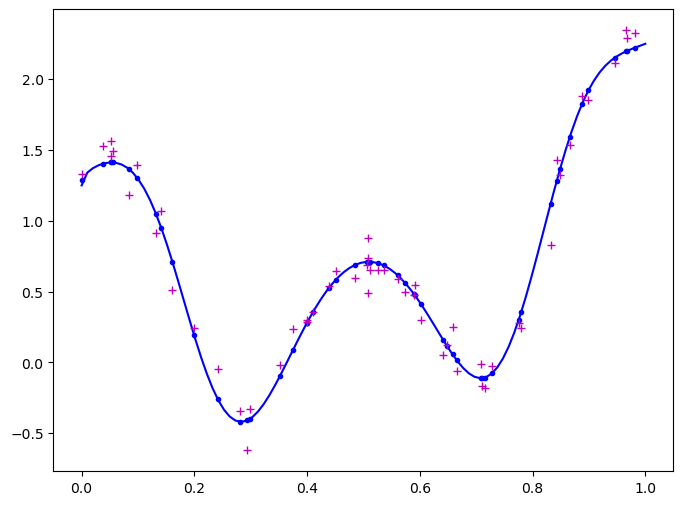

In [2]:
xax = np.linspace(0, 1, num=100)
func1 = (
    lambda x: (x - 0.5) ** 2 + np.cos(np.pi * x**2 * (x - 1) ** 2 * 24) + np.sqrt(x)
)
# func1 = lambda x: 2*x - 1 + np.cos(np.pi*x)/2
# Observations
N_obsv = 55
x_obsv = np.random.rand(N_obsv, 1)
# NOTE: it is important that x_obsv has 2 dims, even if the last one is singleton
y_obsv = func1(x_obsv)
y_noisy_obsv = y_obsv + np.random.randn(N_obsv, 1) / 10
plt.plot(xax, func1(xax), "b")
plt.plot(x_obsv, y_obsv, "b.")
plt.plot(x_obsv, y_noisy_obsv, "m+")
plt.gcf().set_size_inches((8, 6))

Text(0.5, 1.0, 'Using noisy observations')

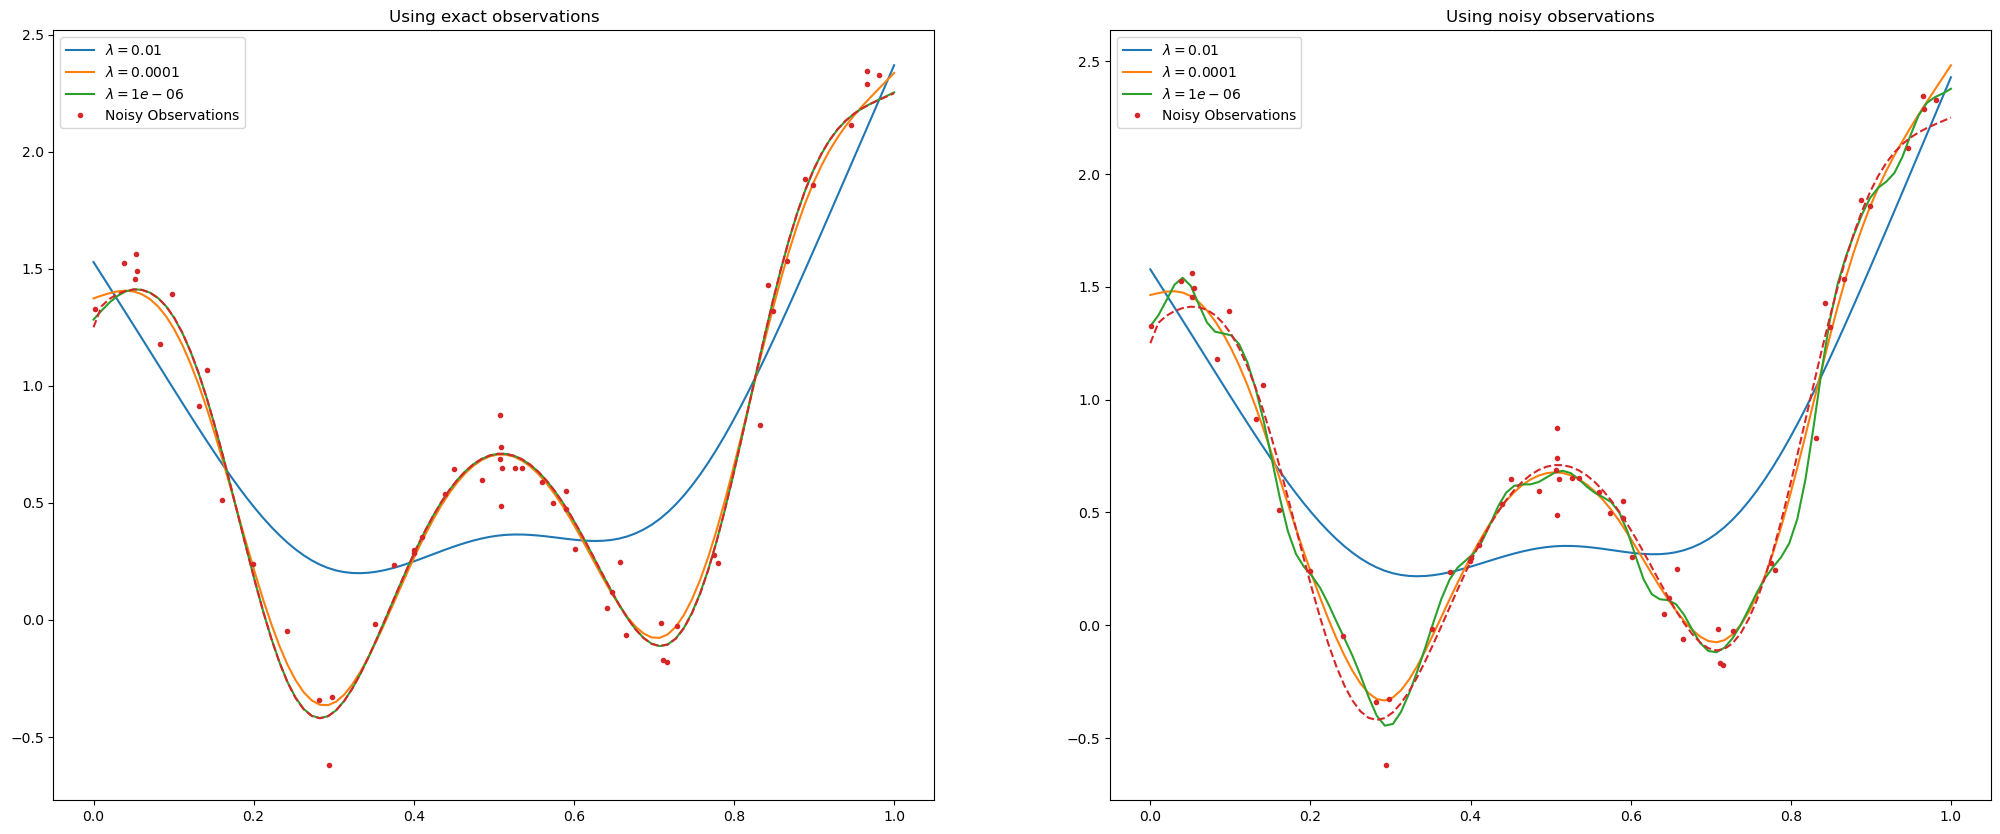

In [3]:
# Bias space with constant and linear term
bias_eval = RKHS.linear_const_eval
# And the default Sine Kernel
sine_kernel = RKHS.SinKernel(max_freq=40)

funcest = RKHS.FunctionEstimator(
    bias_func_eval=bias_eval, kernel_func_eval=sine_kernel.eval
)

fig, ax = plt.subplots(1, 2)
for q in [1 / 100, 1 / 10000, 1 / 1000000]:
    funcest.fit(
        x_obsv, y_obsv, data_cost_weight=100 / N_obsv, rkhs_weight=q, bias_weight=0
    )
    ax[0].plot(xax, funcest.eval(xax[:, np.newaxis]), label=f"$\lambda={q}$")
    funcest.fit(
        x_obsv,
        y_noisy_obsv,
        data_cost_weight=100 / N_obsv,
        rkhs_weight=q,
        bias_weight=0,
    )
    ax[1].plot(xax, funcest.eval(xax[:, np.newaxis]), label=f"$\lambda={q}$")

# plt.plot(xax, funcest.eval(xax[:,np.newaxis]))
for a in ax:
    curr_line = a.plot(xax, func1(xax), "--")
    a.plot(
        x_obsv,
        y_noisy_obsv,
        ".",
        color=curr_line[0].get_color(),
        label="Noisy Observations",
    )
    a.legend()
    a.axis("tight")
ax[0].set_title("Using exact observations")
ax[1].set_title("Using noisy observations")

## Bivariate function
The next example is a function $f(x,y)$ of two variables.

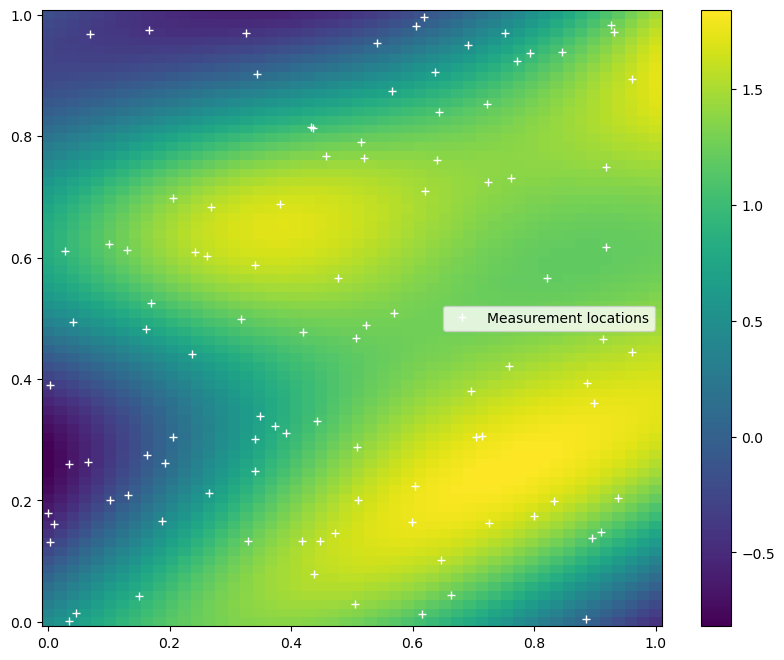

In [4]:
Nx, Ny = (50, 70)
X, Y = np.meshgrid(np.linspace(0, 1, Nx), np.linspace(0, 1, Ny))

func2 = (
    lambda x, y: x * y
    + np.sin(np.pi * (x - y))
    + np.cos(0.5 + 3 * np.pi * (-x / 3 + y)) / 2
    + 2 * np.exp(-5 * (x - 0.3) ** 2 - 10 * (y - 0.6) ** 2)
)

Z = func2(X, Y)
plt.pcolormesh(X, Y, Z, cmap="viridis")
plt.colorbar()
plt.axis("equal")

N_obsv = 100
X_obsv = np.random.rand(N_obsv, 2)
Y_obsv = func2(X_obsv[:, 0], X_obsv[:, 1])[:, np.newaxis]
plt.plot(X_obsv[:, 0], X_obsv[:, 1], "w+", label="Measurement locations")
plt.gcf().set_size_inches((10, 8))
plt.axis("tight")
plt.legend()

Define the `FunctionEstimator` object and fit.

In [5]:
# Bias space with constant and linear term
bias_eval = RKHS.linear_const_eval
# And the default Sine Kernel
sine_kernel2 = RKHS.SinKernel(max_freq=20)

funcest2 = RKHS.FunctionEstimator(
    bias_func_eval=bias_eval, kernel_func_eval=sine_kernel2.eval
)

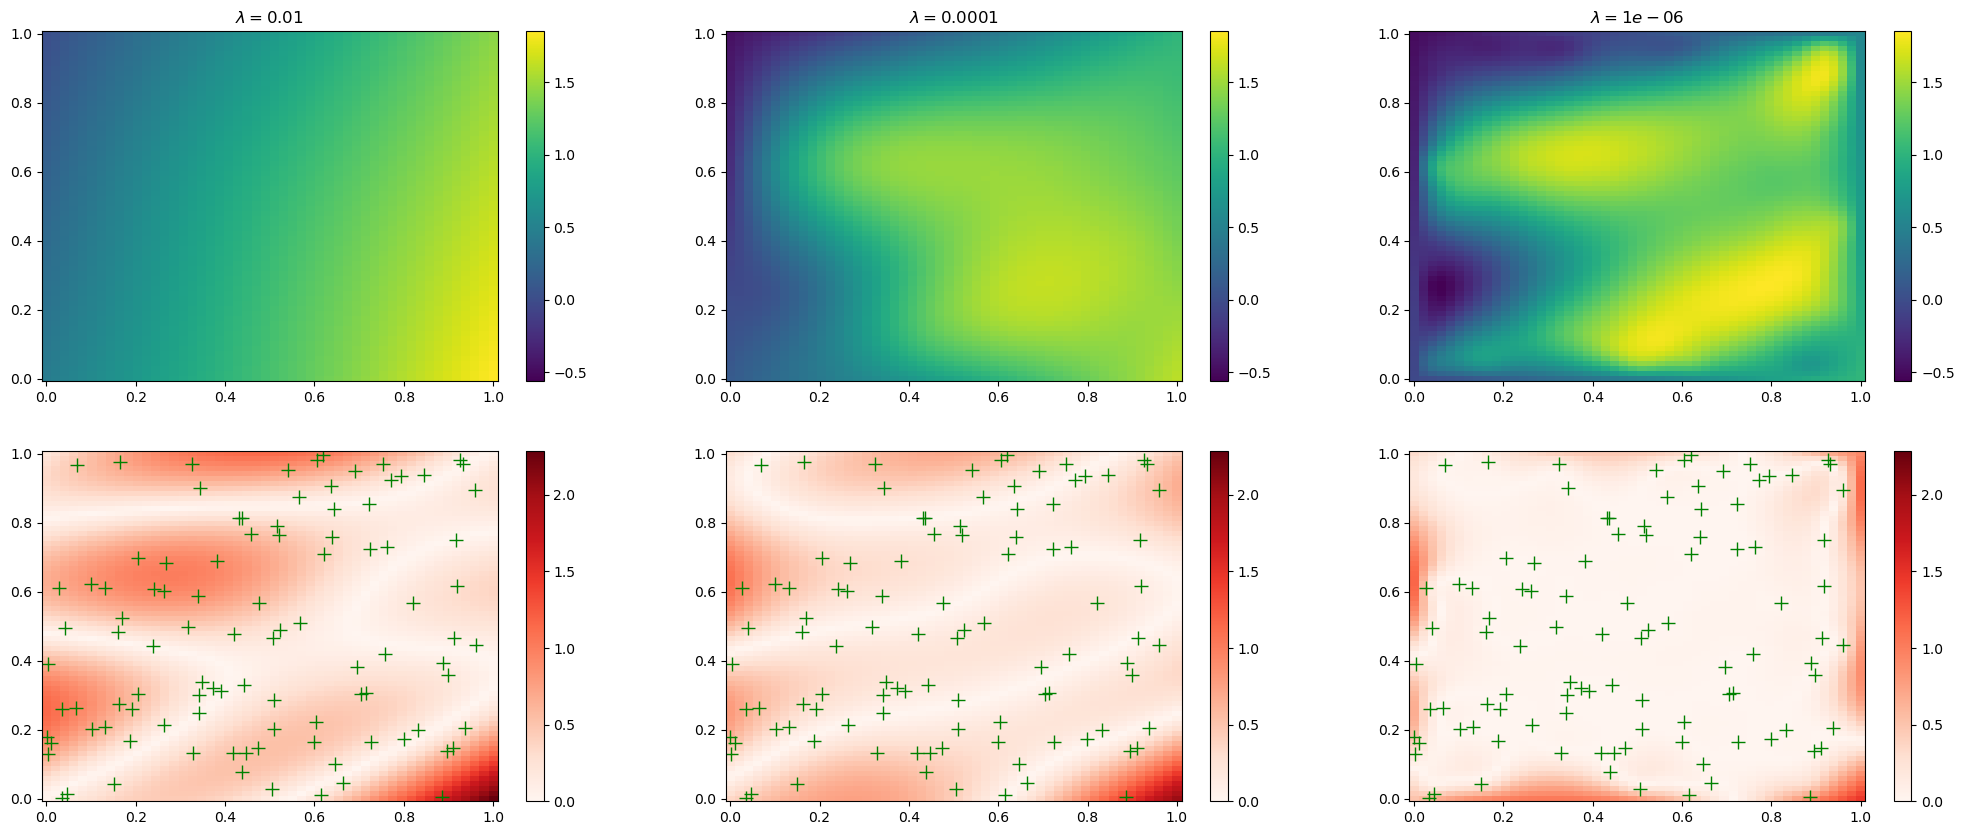

In [6]:
max_diff = 0
max_z, min_z = (-np.inf, np.inf)  # to scale the colormaps
pcm_z = []
pcm_diff = []
fig, ax = plt.subplots(2, 3)
for ii, q in enumerate([1 / 100, 1 / 10000, 1 / 1000000]):
    funcest2.fit(X_obsv, Y_obsv, data_cost_weight=1 / N_obsv, rkhs_weight=q)
    Zest = funcest2.eval(np.column_stack((X.flatten(), Y.flatten()))).reshape(X.shape)
    pcm = ax[0, ii].pcolormesh(X, Y, Zest, cmap="viridis")
    pcm_z.append(pcm)
    # plt.colorbar(pcm, ax=ax[0,ii])
    ax[0, ii].set_title(f"$\lambda={q}$")
    pcm = ax[1, ii].pcolormesh(X, Y, np.abs(Z - Zest), cmap="Reds")
    # plt.colorbar(pcm, ax=ax[1,ii])
    pcm_diff.append(pcm)
    ax[1, ii].plot(X_obsv[:, 0], X_obsv[:, 1], "g+", markersize=10)

    max_diff = max(max_diff, np.max(np.abs(Z - Zest)))
    min_z = min(min_z, np.min(Zest))
    max_z = max(max_z, np.max(Zest))

for ia in range(3):
    # set all the colormaps to the same limits and add colorbars
    pcm_z[ia].set_clim((min_z, max_z))
    plt.colorbar(pcm_z[ia], ax=ax[0, ia])
    pcm_diff[ia].set_clim((0, max_diff))
    plt.colorbar(pcm_diff[ia], ax=ax[1, ia])

for a in ax.flat:
    a.axis("tight")
    # a.axis('equal')

# System Identification
* Scalar autonomous system, i.e. $x[t+1] =  M( x[t], x[t-1], ..., x[t-m+1])$
* Scalar system with exogenous input, i.e. $x[t+1] = M( x[t], ..., x[t-m+1], u[t], ..., u[t-k+1])$
* Multi-dimensional autonomous system, i.e. $X[t+1] = ( M_1(X[t], ..., X[t-m+1]), M_2(X[t], ..., X[t-m+1]), ..., M_d(X[t], ..., X[t-m+1]) )$
* Multi-dimensional system with exogenous inputs, i.e. $X[t+1] = ( M_1(X[t], ..., U[t], ...), M_2(X[t], ..., U[t]), ..., M_d(X[t], ..., U[t]) )$

Note: while it is conceptually no problem to have different delays $m_{11}, ..., m_{dd}$, where $m_{ij}$ is the maximal delay of $X_j$ in $M_i$ (in other words, the term $X_j[t-m_{ij}+2]$ appears in $M_i$), this is not yet implemented, so all we have is $m_{11} = m_{12} = ... = m$=`traj_delays`. Same for the exogenous inputs $U$, where all delays are `exo_delays`.  
However, $k\neq m$ is no problem.

### System definitions and data generation
Note: the same exogenous inputs `U` are used for all of the non-autonomous systems, for convenience.

In [2]:
# Autonomous maps
def logmap(x, r=3.6):
    return x * (1 - x) * r


def stdmap(x):
    # right hand side of Standard Map, scaled to [0,1]x[0,1]
    K = 0.6
    p = x[0]
    th = x[1]
    return np.mod(
        np.array(
            [
                p + K * np.sin(2 * np.pi * th) / 2 / np.pi,
                th + p + K * np.sin(2 * np.pi * th) / 2 / np.pi,
            ]
        ),
        1,
    )


# scalar i/o systems
def arx1(a=0.5, b=0.25):
    # just a scalar arx(1) system
    return lambda x, u: a * x + b * u


def narx1(a=0.5, b=0.25, c=0.3):
    # linear arx(1) system, plus a nonlinearity with delay=2
    lin = arx1(a, b)
    return lambda x1x2, u: lin(x1x2[1], u) + c * x1x2[0] ** 3


# vector valued i/o system
def varx1(A=np.array([[0.5, 0.2], [-0.1, 0.75]]), B=np.array([[1], [-1]])):
    # Multi-ouput ARX(1) system
    rhs = lambda X, U: A @ X + B @ U
    rhs.n = A.shape[0]
    rhs.nu = B.shape[1]
    return rhs


# VAR with delay 2
def varx2(
    A=(np.array([[0.5, 0.2], [-0.1, 0.75]]), np.array([[0.2, -0.2], [0.5, 0.05]])),
    B=(np.array([[1], [-1]]), np.array([[0.1], [-0.1]])),
):
    # Multi-ouput ARX(2) system
    rhs = lambda X12, U12: A[0] @ X12[1] + A[1] @ X12[0] + B[0] @ U12[1] + B[1] @ U12[0]
    rhs.A0 = A[0]
    rhs.A1 = A[1]
    rhs.B0 = B[0]
    rhs.B1 = B[1]
    rhs.n = A[0].shape[0]
    rhs.nu = B[0].shape[1]
    return rhs

In [3]:
N_traj = 3
T = 25
rhs1 = arx1()
rhs2 = narx1()
rhs3 = varx1()
rhs4 = varx2()
Y_log = []
Y_std = []
Y1 = []
Y2 = []
Y3 = []
Y4 = []
U = []

for pp in range(N_traj):
    # pre-allocate trajectories and add initial values
    y_log = np.zeros((T, 1)) + np.nan
    y_log[0, 0] = np.random.rand()
    y_std = np.zeros((T, 2)) + np.nan
    y_std[0, :] = np.random.rand(1, 2)
    y1 = np.zeros((T, 1)) + np.nan
    y1[0, 0] = np.random.rand()
    y2 = np.zeros((T, 1)) + np.nan
    y2[:2, [0]] = np.random.rand(2, 1)
    y3 = np.zeros((T, 2)) + np.nan
    y3[0, :] = np.random.rand(1, 2)
    y4 = np.zeros((T, 2)) + np.nan
    y4[:2, :] = np.random.rand(2, 2)
    # input signal
    U.append(np.random.rand(T, 1))
    for tt in range(T - 1):
        y_log[tt + 1, :] = logmap(y_log[tt, :])
        y_std[tt + 1, :] = stdmap(y_std[tt, :])
        y1[tt + 1, :] = rhs1(y1[tt, :], U[pp][tt, :])
        y3[tt + 1, :] = rhs3(y3[tt, :], U[pp][tt, :])

    Y_log.append(y_log)
    Y_std.append(y_std)
    Y1.append(y1)
    Y3.append(y3)
    for tt in range(T - 2):
        y2[tt + 2, :] = rhs2(y2[tt : tt + 2, :], U[pp][tt + 1, :])
        y4[tt + 2, :] = rhs4(y4[tt : tt + 2, :], U[pp][tt : tt + 2, :])
    Y2.append(y2)
    Y4.append(y4)

Text(0.5, 1.0, 'VARX, inputs')

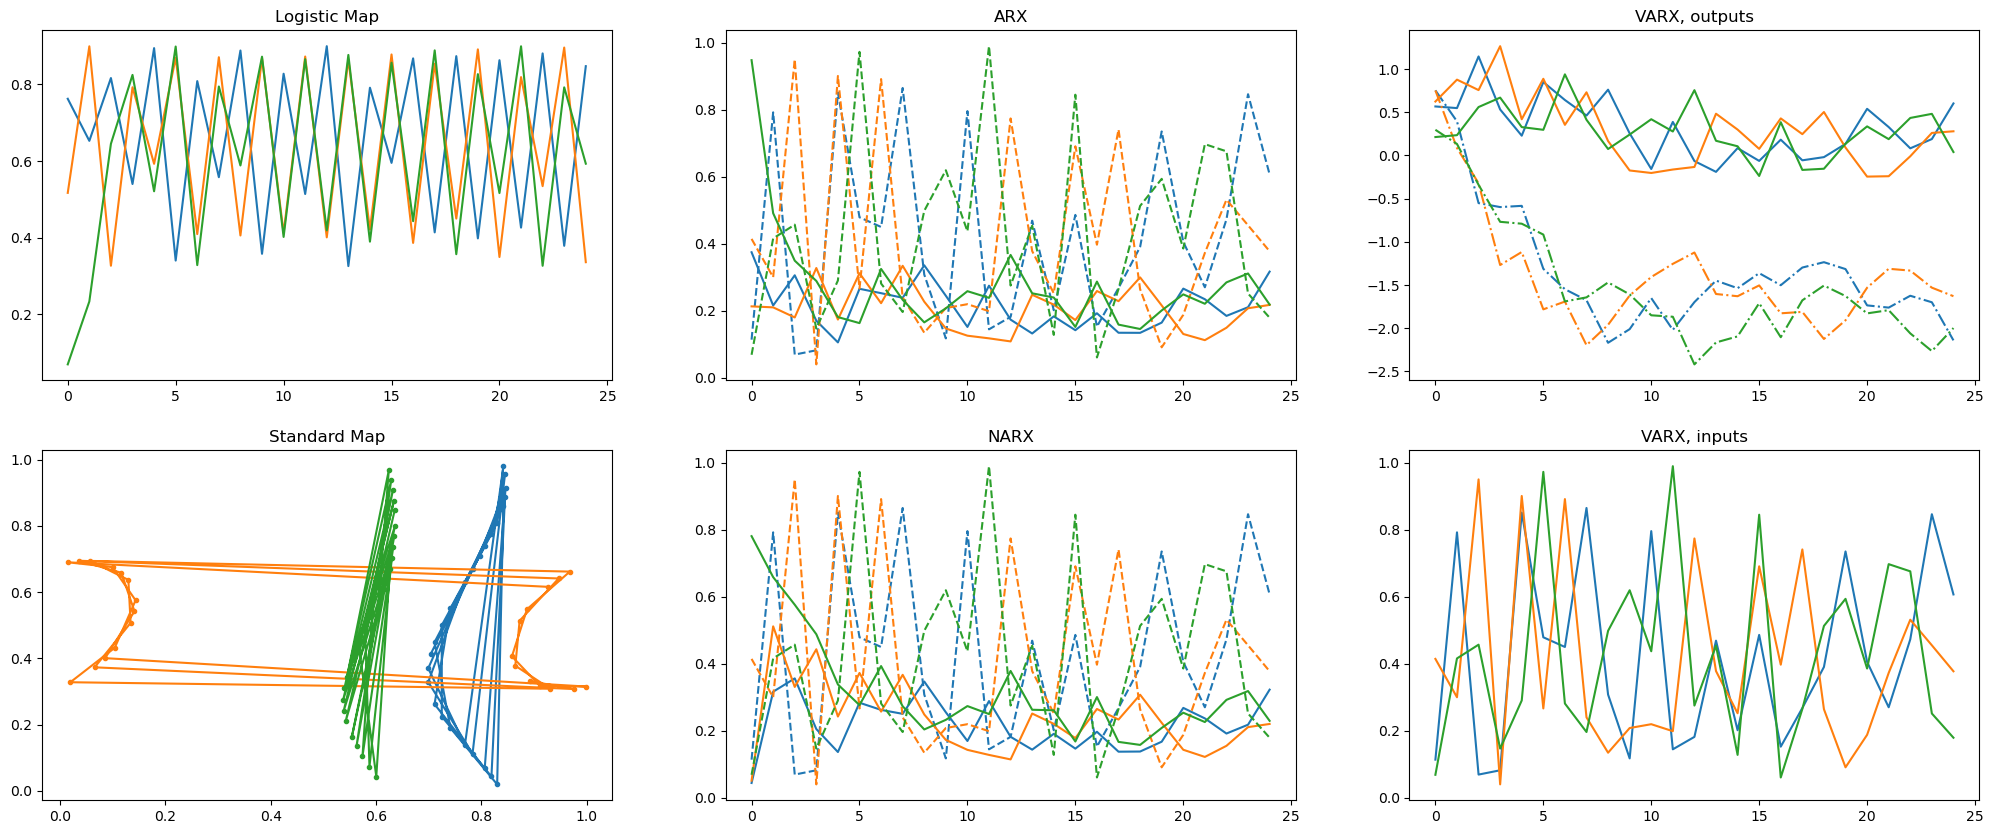

In [4]:
fig, ax = plt.subplots(2, 3)
for y in Y_log:
    ax[0, 0].plot(y)
ax[0, 0].set_title("Logistic Map")
for y in Y_std:
    ax[1, 0].plot(y[:, 0], y[:, 1], ".-")
ax[1, 0].set_title("Standard Map")
for y, u in zip(Y1, U):
    curr_line = ax[0, 1].plot(y)
    ax[0, 1].plot(u, "--", color=curr_line[0].get_color())
ax[0, 1].set_title("ARX")
for y, u in zip(Y2, U):
    curr_line = ax[1, 1].plot(y)
    ax[1, 1].plot(u, "--", color=curr_line[0].get_color())
ax[1, 1].set_title("NARX")
for y, u in zip(Y3, U):
    curr_line = ax[0, 2].plot(y[:, 0])
    ax[0, 2].plot(y[:, 1], "-.", color=curr_line[0].get_color())
    ax[1, 2].plot(u, "-", color=curr_line[0].get_color())
ax[0, 2].set_title("VARX, outputs")
ax[1, 2].set_title("VARX, inputs")

### Estimator object
The dynamical system estimation is handled by the `DynamicalSystemEstimator` object.  
It provides a few convenience methods, e.g. `simulate` and `k_step_ahead`.

In [5]:
# bias_eval3 = RKHS.linear_const_eval
# sine_kernel3 = RKHS.SinKernel(max_freq=20)
# dynest = RKHS.DynamicalSystemEstimator(bias_func_eval=bias_eval3, kernel_func_eval=sine_kernel3.eval)

# A RKHS model
bias_eval3 = RKHS.linear_const_eval
sine_kernel3 = RKHS.SinKernel(max_freq=20)
dynest = RKHS.DynamicalSystemEstimator(
    bias_func_eval=bias_eval3, kernel_func_eval=sine_kernel3.eval
)
dynest_increment = RKHS.DynamicalSystemEstimator(
    bias_func_eval=bias_eval3, kernel_func_eval=sine_kernel3.eval, target_increment=True
)
# A linear sys ID model
import sklearn.linear_model as lm
from sklearn.base import clone

linreg = lm.LinearRegression()  #  regular linear regression
ridge = lm.Ridge(
    alpha=1 / 100
)  # ridge regression. alpha is the weight on L2 norm of coeffs
VAR = RKHS.dynsysestimator.DynamicalSystemEstimatorVAR(linear_model=clone(linreg))
VAR_increment = RKHS.dynsysestimator.DynamicalSystemEstimatorVAR(
    linear_model=clone(linreg), target_increment=True
)

A1: 
 [[ 0.5   0.2 ]
 [-0.1   0.75]]
A2: 
 [[ 0.2  -0.2 ]
 [ 0.5   0.05]]
B1: 
 [[ 1.]
 [-1.]]
B2: 
 [[ 0.1]
 [-0.1]]
C [-1.11022302e-15  6.10622664e-16]


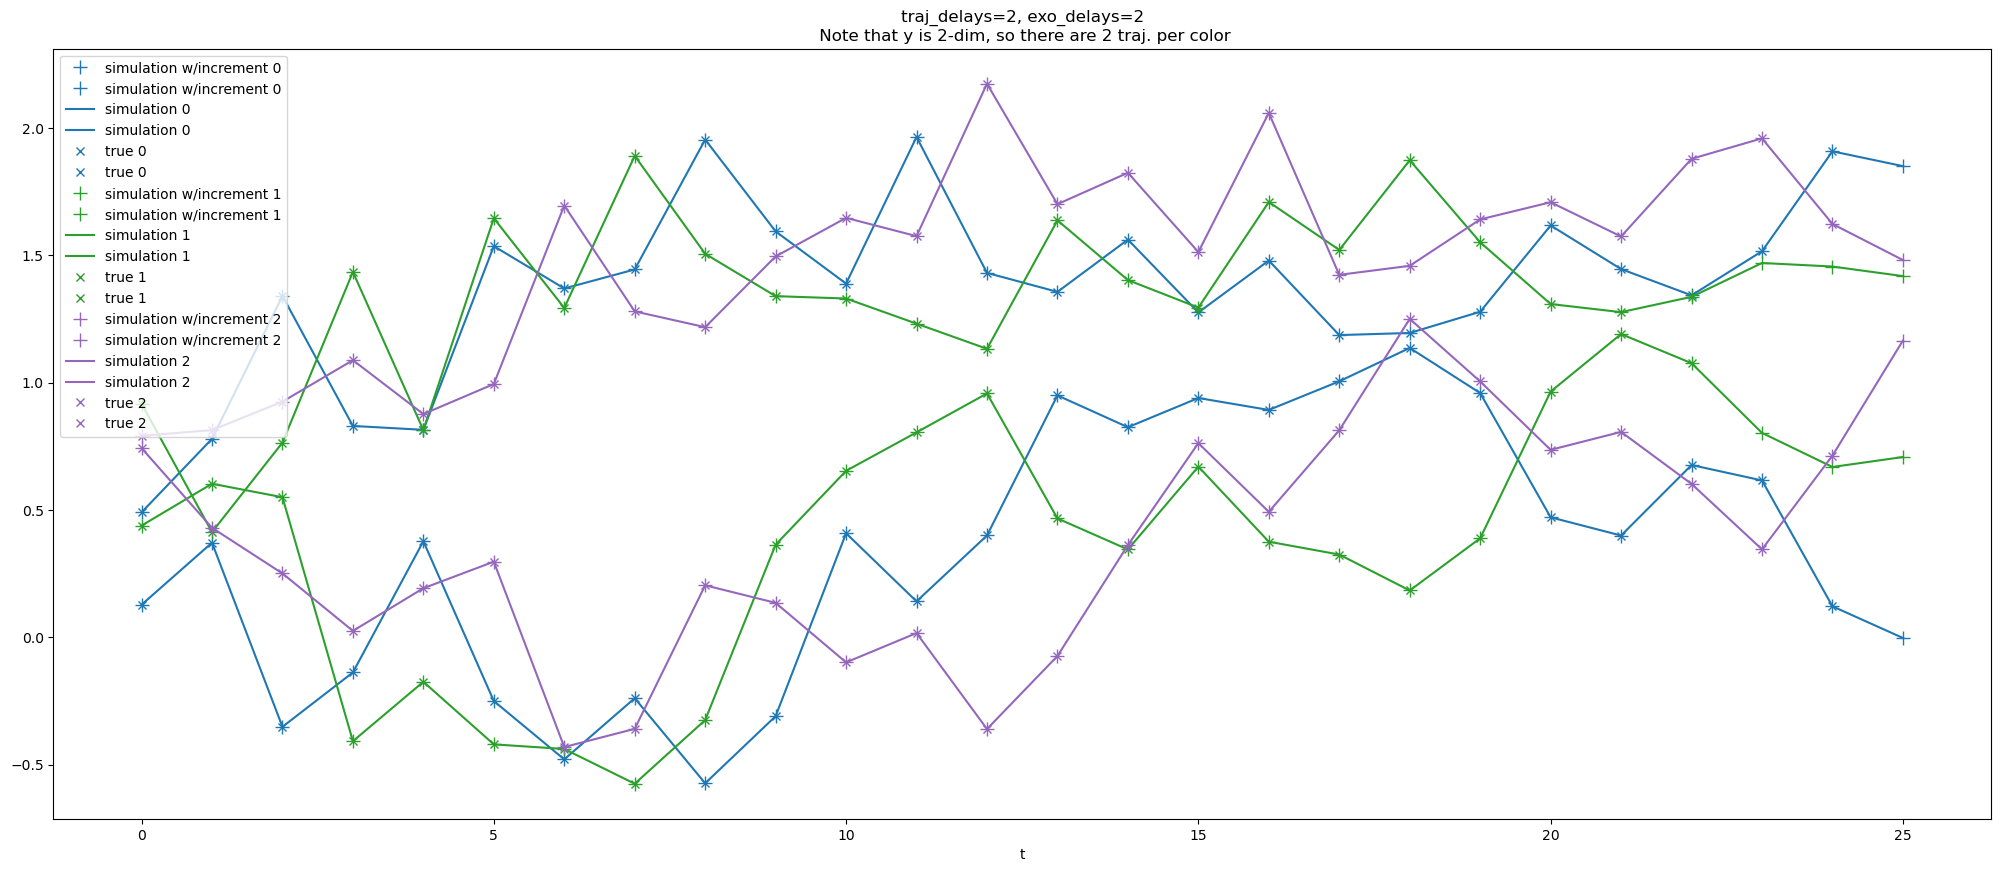

In [9]:
# Still needs to be incorporated into the next few cells
# Try mis-matching the delays with the true model to see what happens if the delays are selected incorrectly
exo_delays = 2
traj_delays = 2
Y_to_fit = Y4.copy()
U_to_fit = U.copy()
# Shortening one of the trajectories to test the case where there are trajectories with different lengths
# Y_to_fit[1] = Y_to_fit[1][:-2,:]
# U_to_fit[1] = U_to_fit[1][:-2,:]
VAR.fit(
    Y_to_fit[:2],
    exogenous_inputs=U_to_fit[:2],
    exo_delays=exo_delays,
    traj_delays=traj_delays,
)
VAR_increment.fit(
    Y_to_fit[:2],
    exogenous_inputs=U_to_fit[:2],
    exo_delays=exo_delays,
    traj_delays=traj_delays,
)

y_lin_sim = VAR.simulate(
    [y[: max(traj_delays, exo_delays), :] for y in Y_to_fit], exogenous_inputs=U
)
y_lin_sim_increment = VAR_increment.simulate(
    [y[: max(traj_delays, exo_delays), :] for y in Y_to_fit], exogenous_inputs=U
)
for ii in range(3):
    curr_line = plt.plot(
        y_lin_sim_increment[ii], "+", label=f"simulation w/increment {ii}", ms=10
    )
    for cl in curr_line:
        cl.set_color(curr_line[0].get_color())
    plt.plot(y_lin_sim[ii], label=f"simulation {ii}", color=curr_line[0].get_color())
    plt.plot(Y_to_fit[ii], "x", label=f"true {ii}", color=curr_line[0].get_color())
plt.legend()
plt.xlabel("t")
plt.title(
    f"traj_delays={traj_delays}, exo_delays={exo_delays}\n Note that y is 2-dim, so there are 2 traj. per color"
)
A, B, C = VAR.coef_
for ia in range(A.shape[2]):
    print(f"A{ia+1}: \n", A[:, :, ia])
for ib in range(B.shape[2]):
    print(f"B{ib+1}: \n", B[:, :, ib])
print("C", C)

### Estimate and evaluate Logistic Map ID

In [12]:
dynest.fit(Y_log, data_cost_weight=1000, bias_weight=0)
dynest_increment.fit(Y_log, data_cost_weight=1000, bias_weight=0)

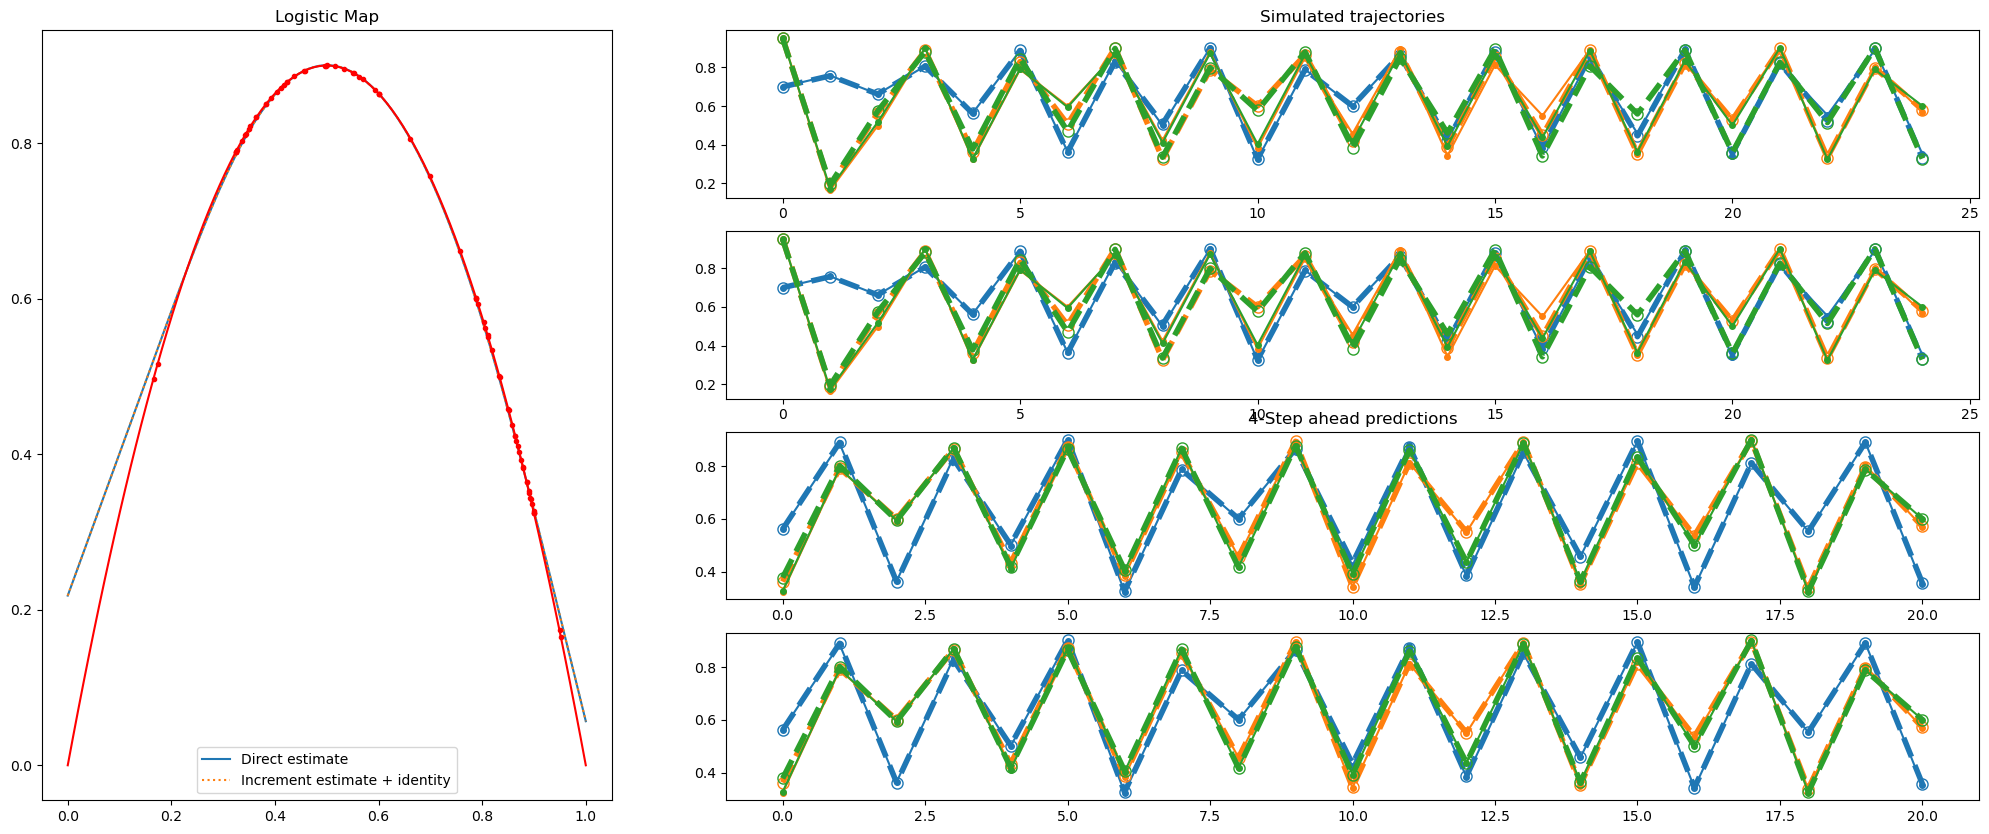

In [13]:
# fig, ax = plt.subplots(1,3)
gs = plt.GridSpec(4, 3)
fig = plt.figure()
ax = [
    fig.add_subplot(gs[:, 0]),
    fig.add_subplot(gs[0, 1:]),
    fig.add_subplot(gs[1, 1:]),
    fig.add_subplot(gs[2, 1:]),
    fig.add_subplot(gs[3, 1:]),
]
# plot true rhs vs estimate
xax = np.linspace(0, 1, num=100)
ax[0].plot(xax, dynest.eval(xax[:, np.newaxis]), label="Direct estimate")
ax[0].plot(
    xax,
    dynest_increment.eval(xax[:, np.newaxis]) + xax[:, np.newaxis],
    ":",
    label="Increment estimate + identity",
)
ax[0].plot(xax, logmap(xax), "r")
for y in Y_log:
    ax[0].plot(y, logmap(y), "r.")
ax[0].set_title("Logistic Map")
ax[0].legend()

# Plot simulations
Y_log_simulated = dynest.simulate([y[[0], :] for y in Y_log], traj_len=T)
Y_log_simulated_increment = dynest_increment.simulate(
    [y[[0], :] for y in Y_log], traj_len=T
)

ax[1].set_title("Simulated trajectories")
for y, ysim in zip(Y_log, Y_log_simulated):
    curr_line = ax[1].plot(y, "-o", ms=4)
    ax[1].plot(ysim, "--o", c=curr_line[0].get_color(), mfc="none", ms=8, lw=4)
for y, ysim in zip(Y_log, Y_log_simulated_increment):
    curr_line = ax[2].plot(y, "-o", ms=4)
    ax[2].plot(ysim, "--o", c=curr_line[0].get_color(), mfc="none", ms=8, lw=4)
# Plot k-step ahead
k_ahead = 4
Y_log_kstep = dynest.k_step_ahead(Y_log, k=k_ahead)
Y_log_kstep_increment = dynest_increment.k_step_ahead(Y_log, k=k_ahead)

ax[3].set_title(f"{k_ahead}-Step ahead predictions")
for y, ystep in zip(Y_log, Y_log_kstep):
    curr_line = ax[3].plot(y[k_ahead:], "o-", ms=4)
    ax[3].plot(ystep, "--o", c=curr_line[0].get_color(), mfc="none", ms=8, lw=4)
for y, ystep in zip(Y_log, Y_log_kstep_increment):
    curr_line = ax[4].plot(y[k_ahead:], "o-", ms=4)
    ax[4].plot(ystep, "--o", c=curr_line[0].get_color(), mfc="none", ms=8, lw=4)

In [14]:
dynest.fit(
    Y3,
    data_cost_weight=10,
    bias_weight=0,
    rkhs_weight=1,
    exogenous_inputs=U,
    exo_delays=1,
)
dynest_increment.fit(
    Y3,
    data_cost_weight=10,
    bias_weight=0,
    rkhs_weight=1,
    exogenous_inputs=U,
    exo_delays=1,
)

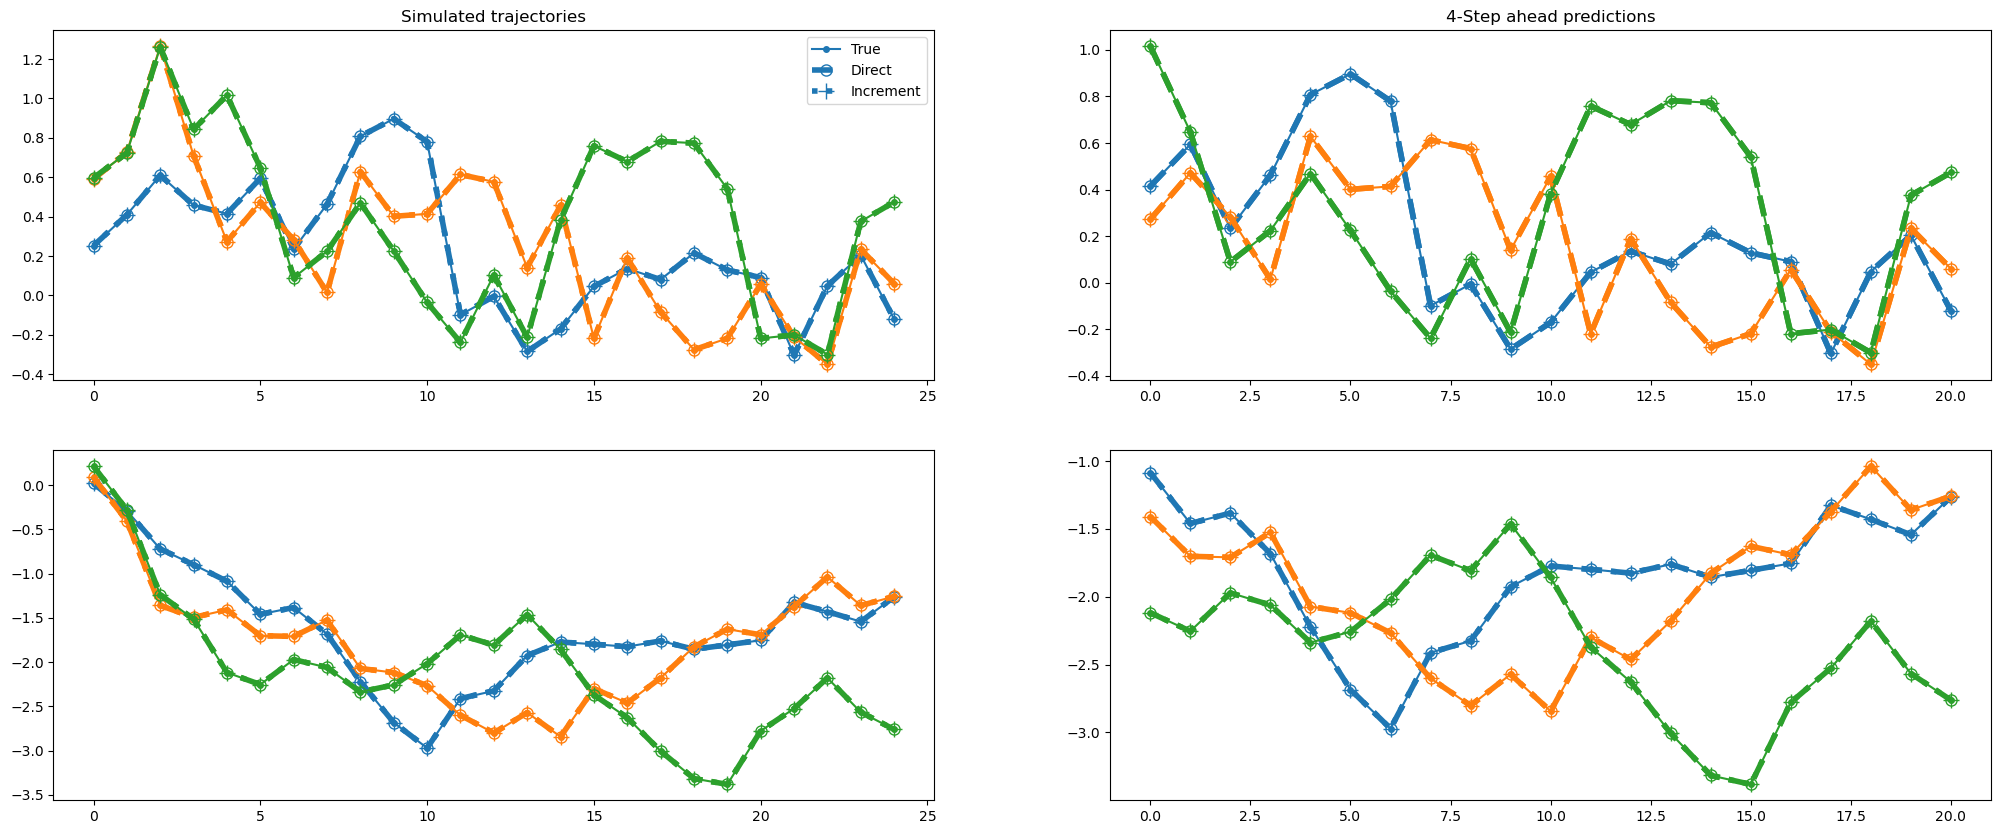

In [15]:
fig, ax = plt.subplots(2, 2)
# plot simulations
Y3_simulated = dynest.simulate([y[[0], :] for y in Y3], exogenous_inputs=U, traj_len=T)
Y3_simulated_increment = dynest_increment.simulate(
    [y[[0], :] for y in Y3], exogenous_inputs=U, traj_len=T
)

ax[0, 0].set_title("Simulated trajectories")
for y, ysim, ysim_increment in zip(Y3, Y3_simulated, Y3_simulated_increment):
    curr_line = ax[0, 0].plot(y[:, 0], "-o", ms=4, label="True")
    ax[0, 0].plot(
        ysim[:, 0],
        "--o",
        c=curr_line[0].get_color(),
        mfc="none",
        ms=8,
        lw=4,
        label="Direct",
    )
    ax[0, 0].plot(
        ysim_increment[:, 0],
        ":+",
        c=curr_line[0].get_color(),
        mfc="none",
        ms=12,
        lw=4,
        label="Increment",
    )

    ax[1, 0].plot(y[:, 1], "-o", c=curr_line[0].get_color(), ms=4)
    ax[1, 0].plot(ysim[:, 1], "--o", c=curr_line[0].get_color(), mfc="none", ms=8, lw=4)
    ax[1, 0].plot(
        ysim_increment[:, 1], ":+", c=curr_line[0].get_color(), mfc="none", ms=12, lw=4
    )

ax[0, 0].legend(["True", "Direct", "Increment"])
# k-step ahead
k_ahead = 4
Y3_kstep = dynest.k_step_ahead(Y3, exogenous_inputs=U, k=k_ahead)
Y3_kstep_increment = dynest_increment.k_step_ahead(Y3, exogenous_inputs=U, k=k_ahead)

ax[0, 1].set_title(f"{k_ahead}-Step ahead predictions")
for y, ystep, ystep_increment in zip(Y3, Y3_kstep, Y3_kstep_increment):
    curr_line = ax[0, 1].plot(y[k_ahead:, 0], "-o", ms=4)
    ax[0, 1].plot(
        ystep[:, 0], "--o", c=curr_line[0].get_color(), mfc="none", ms=8, lw=4
    )
    ax[0, 1].plot(
        ystep_increment[:, 0],
        "--+",
        c=curr_line[0].get_color(),
        mfc="none",
        ms=12,
        lw=4,
    )

    ax[1, 1].plot(y[k_ahead:, 1], "-o", c=curr_line[0].get_color(), ms=4)
    ax[1, 1].plot(
        ystep[:, 1], "--o", c=curr_line[0].get_color(), mfc="none", ms=8, lw=4
    )
    ax[1, 1].plot(
        ystep_increment[:, 1], ":+", c=curr_line[0].get_color(), mfc="none", ms=12, lw=4
    )

In [16]:
# The whole thing, but with noise
rng = np.random.default_rng(3141515)
noise_variance = 0.2
Y3_noise = [y + rng.standard_normal(size=y.shape) * noise_variance for y in Y3]

dynest.fit(
    Y3_noise,
    data_cost_weight=10,
    bias_weight=0,
    rkhs_weight=1,
    exogenous_inputs=U,
    exo_delays=1,
)
dynest_increment.fit(
    Y3_noise,
    data_cost_weight=10,
    bias_weight=0,
    rkhs_weight=1,
    exogenous_inputs=U,
    exo_delays=1,
)

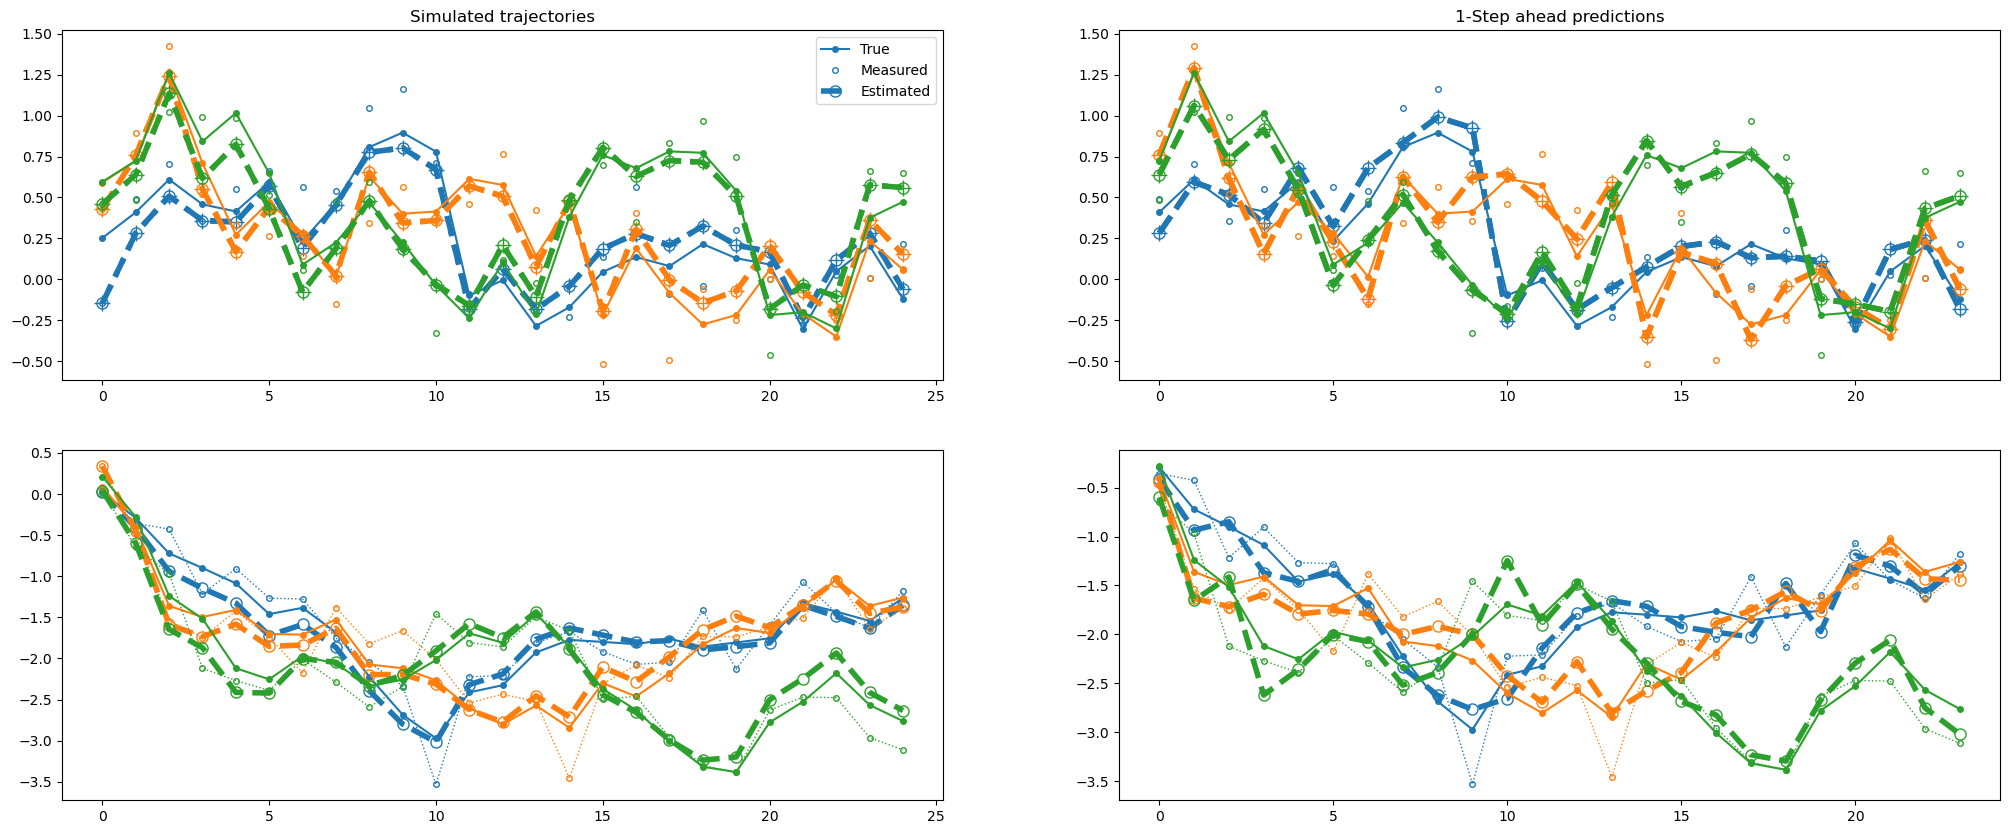

In [20]:
fig, ax = plt.subplots(2, 2)
# plot simulations
Y3_simulated = dynest.simulate(
    [y_n[[0], :] for y_n in Y3_noise], exogenous_inputs=U, traj_len=T
)
Y3_simulated_increment = dynest_increment.simulate(
    [y_n[[0], :] for y_n in Y3_noise], exogenous_inputs=U, traj_len=T
)

ax[0, 0].set_title("Simulated trajectories")
for y, y_n, ysim, ysim_increment in zip(
    Y3, Y3_noise, Y3_simulated, Y3_simulated_increment
):
    curr_line = ax[0, 0].plot(y[:, 0], "-o", ms=4, label="True")
    ax[0, 0].plot(
        y_n[:, 0],
        ".",
        c=curr_line[0].get_color(),
        mfc="none",
        ms=8,
        lw=4,
        label="Measured",
    )
    ax[0, 0].plot(
        ysim[:, 0],
        "--o",
        c=curr_line[0].get_color(),
        mfc="none",
        ms=8,
        lw=4,
        label="Direct",
    )
    # ax[0, 0].plot(ysim_increment[:, 0], ':+', c=curr_line[0].get_color(), mfc='none', ms=12, lw=4, label='Increment')

    ax[1, 0].plot(y[:, 1], "-o", c=curr_line[0].get_color(), ms=4)
    ax[1, 0].plot(y_n[:, 1], ".", c=curr_line[0].get_color(), mfc="none", ms=8, lw=1)
    ax[1, 0].plot(ysim[:, 1], "--o", c=curr_line[0].get_color(), mfc="none", ms=8, lw=4)
    # ax[1, 0].plot(ysim_increment[:, 1], ':+', c=curr_line[0].get_color(), mfc='none', ms=12, lw=4)

ax[0, 0].legend(["True", "Measured", "Estimated"])
# k-step ahead
k_ahead = 1
Y3_kstep = dynest.k_step_ahead(Y3_noise, exogenous_inputs=U, k=k_ahead)
Y3_kstep_increment = dynest_increment.k_step_ahead(
    Y3_noise, exogenous_inputs=U, k=k_ahead
)

ax[0, 1].set_title(f"{k_ahead}-Step ahead predictions")
for y, y_n, ystep, ystep_increment in zip(Y3, Y3_noise, Y3_kstep, Y3_kstep_increment):
    curr_line = ax[0, 1].plot(y[k_ahead:, 0], "-o", ms=4)
    ax[0, 1].plot(
        y_n[k_ahead:, 0], ".", c=curr_line[0].get_color(), mfc="none", ms=8, lw=1
    )
    ax[0, 1].plot(
        ystep[:, 0], "--o", c=curr_line[0].get_color(), mfc="none", ms=8, lw=4
    )
    # ax[0, 1].plot(ystep_increment[:, 0], '--+', c=curr_line[0].get_color(), mfc='none', ms=12, lw=4)

    ax[1, 1].plot(y[k_ahead:, 1], "-o", c=curr_line[0].get_color(), ms=4)
    ax[1, 1].plot(
        y_n[k_ahead:, 1], ".", c=curr_line[0].get_color(), mfc="none", ms=8, lw=1
    )
    ax[1, 1].plot(
        ystep[:, 1], "--o", c=curr_line[0].get_color(), mfc="none", ms=8, lw=4
    )
    # ax[1, 1].plot(ystep_increment[:, 1], ':+', c=curr_line[0].get_color(), mfc='none', ms=12, lw=4)
# NOTE: The increment estimates are still identical to the direct estimates. This is surprising, we should
#       think about that.

# Still to be added
* fitting and evalution for the other dynamical systems
* adding noise to the measurements
* "wrong" delays -- what if we set delays to number too high/too low?
* cross-validation to select weights

_Copyright IBM Corp. 2023_

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.